In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

FRAC_ADMIT = 0.5


In [2]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [3]:
df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = df_stratum_utility['Y'] 
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [4]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [5]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 10000
GRID_SIZE = 100

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 29349
100 29402
200 29453
300 29505
400 29551
500 29594
600 29632
700 29675
800 29715
900 29755
1000 29794
1100 29832
1200 29875
1300 29906
1400 29937
1500 29969
1600 29993
1700 30024
1800 30050
1900 30084
2000 30115
2100 30150
2200 30179
2300 30214
2400 30243
2500 30265
2600 30287
2700 30302
2800 30323
2900 30354
3000 30377
3100 30397
3200 30432
3300 30444
3400 30485
3500 30503
3600 30519
3700 30539
3800 30562
3900 30583
4000 30597
4100 30607
4200 30616
4300 30637
4400 30656
4500 30691
4600 30717
4700 30730
4800 30736
4900 30728
5000 30742
5100 30755
5200 30782
5300 30793
5400 30803
5500 30821
5600 30832
5700 30850
5800 30860
5900 30878
6000 30880
6100 30884
6200 30882
6300 30895
6400 30891
6500 30900
6600 30917
6700 30931
6800 30929
6900 30930
7000 30936
7100 30932
7200 30933
7300 30934
7400 30930
7500 30939
7600 30945
7700 30939
7800 30940
7900 30954
8000 30948
8100 30962
8200 30957
8300 30965
8400 30965
8500 30981
8600 30986
8700 30982
8800 30967
8900 30960
9000 30938
9100 30939


In [6]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

dff = df[['R','T','Y']].groupby(['R','T']).count().reset_index()
dff.columns = ['R','T','N']
dff['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)
dff2 = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
dff2.columns = ['R','T','Y']
dff2['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)

dff = dff.merge(dff2[['key','Y']],on='key')

In [7]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True)


In [8]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [10]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,101):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions:

Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions:

Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions:

Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.09
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells ch

Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.11
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions:

Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions:

Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions: 0
Total grid cells checked so far: 36000/63300, Solutions: 0
Total grid cells checked so far: 37000/63300, Solutions: 0
Total grid cells checked so far: 38000/63300, Solutions: 0
Total grid cells checked so far: 39000/63300, Solutions: 0
Total grid cells checked so far: 40000/63300, Solutions: 0
Total grid cells checked so far: 41000/63300, Solutions: 0
Total grid cells checked so far: 42000/63300, Solutions: 0
Total grid cells checked so far: 43000/63300, Solutions: 0
Total grid cells checked so far: 44000/63300, Solutions: 0
Total grid cells checked so far: 45000/63300, Solutions: 0
Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions:

Total grid cells checked so far: 46000/63300, Solutions: 0
Total grid cells checked so far: 47000/63300, Solutions: 0
Total grid cells checked so far: 48000/63300, Solutions: 0
Total grid cells checked so far: 49000/63300, Solutions: 0
Total grid cells checked so far: 50000/63300, Solutions: 0
Total grid cells checked so far: 51000/63300, Solutions: 0
Total grid cells checked so far: 52000/63300, Solutions: 0
Total grid cells checked so far: 53000/63300, Solutions: 0
Total grid cells checked so far: 54000/63300, Solutions: 0
Total grid cells checked so far: 55000/63300, Solutions: 0
Total grid cells checked so far: 56000/63300, Solutions: 0
Total grid cells checked so far: 57000/63300, Solutions: 0
Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions:

Total grid cells checked so far: 58000/63300, Solutions: 0
Total grid cells checked so far: 59000/63300, Solutions: 0
Total grid cells checked so far: 60000/63300, Solutions: 0
Total grid cells checked so far: 61000/63300, Solutions: 0
Total grid cells checked so far: 62000/63300, Solutions: 0
Total grid cells checked so far: 63000/63300, Solutions: 0
0.22
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0


Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions: 0
Total grid cells checked so far: 30000/63300, Solutions: 0
Total grid cells checked so far: 31000/63300, Solutions: 0
Total grid cells checked so far: 32000/63300, Solutions: 0
Total grid cells checked so far: 33000/63300, Solutions: 0
Total grid cells checked so far: 34000/63300, Solutions: 0
Total grid cells checked so far: 35000/63300, Solutions:

Total grid cells checked so far: 31000/63300, Solutions: 150
Total grid cells checked so far: 32000/63300, Solutions: 150
Total grid cells checked so far: 33000/63300, Solutions: 150
Total grid cells checked so far: 34000/63300, Solutions: 150
Total grid cells checked so far: 35000/63300, Solutions: 150
Total grid cells checked so far: 36000/63300, Solutions: 150
Total grid cells checked so far: 37000/63300, Solutions: 150
Total grid cells checked so far: 38000/63300, Solutions: 150
Total grid cells checked so far: 39000/63300, Solutions: 150
Total grid cells checked so far: 40000/63300, Solutions: 150
Total grid cells checked so far: 41000/63300, Solutions: 150
Total grid cells checked so far: 42000/63300, Solutions: 150
Total grid cells checked so far: 43000/63300, Solutions: 150
Total grid cells checked so far: 44000/63300, Solutions: 150
Total grid cells checked so far: 45000/63300, Solutions: 150
Total grid cells checked so far: 46000/63300, Solutions: 150
Total grid cells checked

Total grid cells checked so far: 39000/63300, Solutions: 1641
Total grid cells checked so far: 40000/63300, Solutions: 1641
Total grid cells checked so far: 41000/63300, Solutions: 1641
Total grid cells checked so far: 42000/63300, Solutions: 1641
Total grid cells checked so far: 43000/63300, Solutions: 1641
Total grid cells checked so far: 44000/63300, Solutions: 1641
Total grid cells checked so far: 45000/63300, Solutions: 1641
Total grid cells checked so far: 46000/63300, Solutions: 1641
Total grid cells checked so far: 47000/63300, Solutions: 1641
Total grid cells checked so far: 48000/63300, Solutions: 1641
Total grid cells checked so far: 49000/63300, Solutions: 1641
Total grid cells checked so far: 50000/63300, Solutions: 1641
Total grid cells checked so far: 51000/63300, Solutions: 1641
Total grid cells checked so far: 52000/63300, Solutions: 1641
Total grid cells checked so far: 53000/63300, Solutions: 1641
Total grid cells checked so far: 54000/63300, Solutions: 1641
Total gr

Total grid cells checked so far: 45000/63300, Solutions: 4875
Total grid cells checked so far: 46000/63300, Solutions: 4875
Total grid cells checked so far: 47000/63300, Solutions: 4875
Total grid cells checked so far: 48000/63300, Solutions: 4875
Total grid cells checked so far: 49000/63300, Solutions: 4875
Total grid cells checked so far: 50000/63300, Solutions: 4875
Total grid cells checked so far: 51000/63300, Solutions: 4875
Total grid cells checked so far: 52000/63300, Solutions: 4875
Total grid cells checked so far: 53000/63300, Solutions: 4875
Total grid cells checked so far: 54000/63300, Solutions: 4875
Total grid cells checked so far: 55000/63300, Solutions: 4875
Total grid cells checked so far: 56000/63300, Solutions: 4875
Total grid cells checked so far: 57000/63300, Solutions: 4875
Total grid cells checked so far: 58000/63300, Solutions: 4875
Total grid cells checked so far: 59000/63300, Solutions: 4875
Total grid cells checked so far: 60000/63300, Solutions: 4875
Total gr

Total grid cells checked so far: 51000/63300, Solutions: 8804
Total grid cells checked so far: 52000/63300, Solutions: 8804
Total grid cells checked so far: 53000/63300, Solutions: 8804
Total grid cells checked so far: 54000/63300, Solutions: 8804
Total grid cells checked so far: 55000/63300, Solutions: 8804
Total grid cells checked so far: 56000/63300, Solutions: 8804
Total grid cells checked so far: 57000/63300, Solutions: 8804
Total grid cells checked so far: 58000/63300, Solutions: 8804
Total grid cells checked so far: 59000/63300, Solutions: 8804
Total grid cells checked so far: 60000/63300, Solutions: 8804
Total grid cells checked so far: 61000/63300, Solutions: 8804
Total grid cells checked so far: 62000/63300, Solutions: 8804
Total grid cells checked so far: 63000/63300, Solutions: 8804
0.35000000000000003
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 8804
Total grid cells checked so far: 2000/63300, Solutions: 8804
Total grid cells ch

Total grid cells checked so far: 56000/63300, Solutions: 13094
Total grid cells checked so far: 57000/63300, Solutions: 13094
Total grid cells checked so far: 58000/63300, Solutions: 13094
Total grid cells checked so far: 59000/63300, Solutions: 13094
Total grid cells checked so far: 60000/63300, Solutions: 13094
Total grid cells checked so far: 61000/63300, Solutions: 13094
Total grid cells checked so far: 62000/63300, Solutions: 13094
Total grid cells checked so far: 63000/63300, Solutions: 13094
0.37
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 13094
Total grid cells checked so far: 2000/63300, Solutions: 13094
Total grid cells checked so far: 3000/63300, Solutions: 13094
Total grid cells checked so far: 4000/63300, Solutions: 13094
Total grid cells checked so far: 5000/63300, Solutions: 13094
Total grid cells checked so far: 6000/63300, Solutions: 13094
Total grid cells checked so far: 7000/63300, Solutions: 13094
Total grid cells checked

Total grid cells checked so far: 60000/63300, Solutions: 17969
Total grid cells checked so far: 61000/63300, Solutions: 17969
Total grid cells checked so far: 62000/63300, Solutions: 17969
Total grid cells checked so far: 63000/63300, Solutions: 17969
0.39
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 17969
Total grid cells checked so far: 2000/63300, Solutions: 17969
Total grid cells checked so far: 3000/63300, Solutions: 17969
Total grid cells checked so far: 4000/63300, Solutions: 17969
Total grid cells checked so far: 5000/63300, Solutions: 17969
Total grid cells checked so far: 6000/63300, Solutions: 17969
Total grid cells checked so far: 7000/63300, Solutions: 17969
Total grid cells checked so far: 8000/63300, Solutions: 17969
Total grid cells checked so far: 9000/63300, Solutions: 17969
Total grid cells checked so far: 10000/63300, Solutions: 17969
Total grid cells checked so far: 11000/63300, Solutions: 17969
Total grid cells checked s

Total grid cells checked so far: 1000/63300, Solutions: 23404
Total grid cells checked so far: 2000/63300, Solutions: 23404
Total grid cells checked so far: 3000/63300, Solutions: 23404
Total grid cells checked so far: 4000/63300, Solutions: 23404
Total grid cells checked so far: 5000/63300, Solutions: 23404
Total grid cells checked so far: 6000/63300, Solutions: 23404
Total grid cells checked so far: 7000/63300, Solutions: 23404
Total grid cells checked so far: 8000/63300, Solutions: 23404
Total grid cells checked so far: 9000/63300, Solutions: 23404
Total grid cells checked so far: 10000/63300, Solutions: 23404
Total grid cells checked so far: 11000/63300, Solutions: 23404
Total grid cells checked so far: 12000/63300, Solutions: 23404
Total grid cells checked so far: 13000/63300, Solutions: 23404
Total grid cells checked so far: 14000/63300, Solutions: 23404
Total grid cells checked so far: 15000/63300, Solutions: 23404
Total grid cells checked so far: 16000/63300, Solutions: 23404
T

Total grid cells checked so far: 6000/63300, Solutions: 29309
Total grid cells checked so far: 7000/63300, Solutions: 29309
Total grid cells checked so far: 8000/63300, Solutions: 29309
Total grid cells checked so far: 9000/63300, Solutions: 29309
Total grid cells checked so far: 10000/63300, Solutions: 29309
Total grid cells checked so far: 11000/63300, Solutions: 29309
Total grid cells checked so far: 12000/63300, Solutions: 29309
Total grid cells checked so far: 13000/63300, Solutions: 29309
Total grid cells checked so far: 14000/63300, Solutions: 29309
Total grid cells checked so far: 15000/63300, Solutions: 29309
Total grid cells checked so far: 16000/63300, Solutions: 29309
Total grid cells checked so far: 17000/63300, Solutions: 29309
Total grid cells checked so far: 18000/63300, Solutions: 29309
Total grid cells checked so far: 19000/63300, Solutions: 29309
Total grid cells checked so far: 20000/63300, Solutions: 29309
Total grid cells checked so far: 21000/63300, Solutions: 29

Total grid cells checked so far: 10000/63300, Solutions: 35039
Total grid cells checked so far: 11000/63300, Solutions: 35039
Total grid cells checked so far: 12000/63300, Solutions: 35039
Total grid cells checked so far: 13000/63300, Solutions: 35039
Total grid cells checked so far: 14000/63300, Solutions: 35039
Total grid cells checked so far: 15000/63300, Solutions: 35039
Total grid cells checked so far: 16000/63300, Solutions: 35039
Total grid cells checked so far: 17000/63300, Solutions: 35039
Total grid cells checked so far: 18000/63300, Solutions: 35039
Total grid cells checked so far: 19000/63300, Solutions: 35039
Total grid cells checked so far: 20000/63300, Solutions: 35039
Total grid cells checked so far: 21000/63300, Solutions: 35039
Total grid cells checked so far: 22000/63300, Solutions: 35039
Total grid cells checked so far: 23000/63300, Solutions: 35039
Total grid cells checked so far: 24000/63300, Solutions: 35039
Total grid cells checked so far: 25000/63300, Solutions

Total grid cells checked so far: 13000/63300, Solutions: 40182
Total grid cells checked so far: 14000/63300, Solutions: 40182
Total grid cells checked so far: 15000/63300, Solutions: 40182
Total grid cells checked so far: 16000/63300, Solutions: 40182
Total grid cells checked so far: 17000/63300, Solutions: 40182
Total grid cells checked so far: 18000/63300, Solutions: 40182
Total grid cells checked so far: 19000/63300, Solutions: 40182
Total grid cells checked so far: 20000/63300, Solutions: 40182
Total grid cells checked so far: 21000/63300, Solutions: 40182
Total grid cells checked so far: 22000/63300, Solutions: 40182
Total grid cells checked so far: 23000/63300, Solutions: 40182
Total grid cells checked so far: 24000/63300, Solutions: 40182
Total grid cells checked so far: 25000/63300, Solutions: 40182
Total grid cells checked so far: 26000/63300, Solutions: 40182
Total grid cells checked so far: 27000/63300, Solutions: 40182
Total grid cells checked so far: 28000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 43493
Total grid cells checked so far: 18000/63300, Solutions: 43493
Total grid cells checked so far: 19000/63300, Solutions: 43493
Total grid cells checked so far: 20000/63300, Solutions: 43493
Total grid cells checked so far: 21000/63300, Solutions: 43493
Total grid cells checked so far: 22000/63300, Solutions: 43493
Total grid cells checked so far: 23000/63300, Solutions: 43493
Total grid cells checked so far: 24000/63300, Solutions: 43493
Total grid cells checked so far: 25000/63300, Solutions: 43493
Total grid cells checked so far: 26000/63300, Solutions: 43493
Total grid cells checked so far: 27000/63300, Solutions: 43493
Total grid cells checked so far: 28000/63300, Solutions: 43493
Total grid cells checked so far: 29000/63300, Solutions: 43493
Total grid cells checked so far: 30000/63300, Solutions: 43493
Total grid cells checked so far: 31000/63300, Solutions: 43493
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 22000/63300, Solutions: 44830
Total grid cells checked so far: 23000/63300, Solutions: 44830
Total grid cells checked so far: 24000/63300, Solutions: 44830
Total grid cells checked so far: 25000/63300, Solutions: 44830
Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions: 44830
Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions

Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions: 44830
Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions

Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions

Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions

Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions

Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions

Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.64
Total grid cells to check: 63300
Total grid cells 

Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.66
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells checked so far: 2000/63300, Solutions: 44830
Total grid cells checked so far: 3000/63300, Solutions: 44830
Total grid cells checked so far: 4000/63300, Solutions: 44830
Total grid cells chec

Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.68
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells checked so far: 2000/63300, Solutions: 44830
Total grid cells checked so far: 3000/63300, Solutions: 44830
Total grid cells checked so far: 4000/63300, Solutions: 44830
Total grid cells checked so far: 5000/63300, Solutions: 44830
Total grid cells checked so far: 6000/63300, Solutions: 44830
Total grid cells checked so far: 7000/63300, Solutions: 44830
Total grid cells checked so far: 8000/63300, Solutions: 44830
Total grid cells checked 

Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.7000000000000001
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells checked so far: 2000/63300, Solutions: 44830
Total grid cells checked so far: 3000/63300, Solutions: 44830
Total grid cells checked so far: 4000/63300, Solutions: 44830
Total grid cells checked so far: 5000/63300, Solutions: 44830
Total grid cells checked so far: 6000/63300, Solutions: 44830
Total grid cells checked so far: 7000/63300, Solutions: 44830
Total grid cells checked so far: 8000/63300, Solutions: 44830
Total grid cells checked so far: 9000/63300, Solutions: 44830
Total grid cells checked so far: 10000/63300, Solutions: 44830
Total grid cells checked so far: 11000/63300, Solutions: 44830
Total grid cells checked so far: 12000/63300, Solutions: 44830
Total grid c

Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells checked so far: 2000/63300, Solutions: 44830
Total grid cells checked so far: 3000/63300, Solutions: 44830
Total grid cells checked so far: 4000/63300, Solutions: 44830
Total grid cells checked so far: 5000/63300, Solutions: 44830
Total grid cells checked so far: 6000/63300, Solutions: 44830
Total grid cells checked so far: 7000/63300, Solutions: 44830
Total grid cells checked so far: 8000/63300, Solutions: 44830
Total grid cells checked so far: 9000/63300, Solutions: 44830
Total grid cells checked so far: 10000/63300, Solutions: 44830
Total grid cells checked so far: 11000/63300, Solutions: 44830
Total grid cells checked so far: 12000/63300, Solutions: 44830
Total grid cells checked so far: 13000/63300, Solutions: 44830
Total grid cells checked so far: 14000/63300, Solutions: 44830
Total grid cells checked so far: 15000/63300, Solutions: 44830
Total grid cells checked so far: 16000/63300, Solutions: 44830
T

Total grid cells checked so far: 5000/63300, Solutions: 44830
Total grid cells checked so far: 6000/63300, Solutions: 44830
Total grid cells checked so far: 7000/63300, Solutions: 44830
Total grid cells checked so far: 8000/63300, Solutions: 44830
Total grid cells checked so far: 9000/63300, Solutions: 44830
Total grid cells checked so far: 10000/63300, Solutions: 44830
Total grid cells checked so far: 11000/63300, Solutions: 44830
Total grid cells checked so far: 12000/63300, Solutions: 44830
Total grid cells checked so far: 13000/63300, Solutions: 44830
Total grid cells checked so far: 14000/63300, Solutions: 44830
Total grid cells checked so far: 15000/63300, Solutions: 44830
Total grid cells checked so far: 16000/63300, Solutions: 44830
Total grid cells checked so far: 17000/63300, Solutions: 44830
Total grid cells checked so far: 18000/63300, Solutions: 44830
Total grid cells checked so far: 19000/63300, Solutions: 44830
Total grid cells checked so far: 20000/63300, Solutions: 448

Total grid cells checked so far: 9000/63300, Solutions: 44830
Total grid cells checked so far: 10000/63300, Solutions: 44830
Total grid cells checked so far: 11000/63300, Solutions: 44830
Total grid cells checked so far: 12000/63300, Solutions: 44830
Total grid cells checked so far: 13000/63300, Solutions: 44830
Total grid cells checked so far: 14000/63300, Solutions: 44830
Total grid cells checked so far: 15000/63300, Solutions: 44830
Total grid cells checked so far: 16000/63300, Solutions: 44830
Total grid cells checked so far: 17000/63300, Solutions: 44830
Total grid cells checked so far: 18000/63300, Solutions: 44830
Total grid cells checked so far: 19000/63300, Solutions: 44830
Total grid cells checked so far: 20000/63300, Solutions: 44830
Total grid cells checked so far: 21000/63300, Solutions: 44830
Total grid cells checked so far: 22000/63300, Solutions: 44830
Total grid cells checked so far: 23000/63300, Solutions: 44830
Total grid cells checked so far: 24000/63300, Solutions:

Total grid cells checked so far: 13000/63300, Solutions: 44830
Total grid cells checked so far: 14000/63300, Solutions: 44830
Total grid cells checked so far: 15000/63300, Solutions: 44830
Total grid cells checked so far: 16000/63300, Solutions: 44830
Total grid cells checked so far: 17000/63300, Solutions: 44830
Total grid cells checked so far: 18000/63300, Solutions: 44830
Total grid cells checked so far: 19000/63300, Solutions: 44830
Total grid cells checked so far: 20000/63300, Solutions: 44830
Total grid cells checked so far: 21000/63300, Solutions: 44830
Total grid cells checked so far: 22000/63300, Solutions: 44830
Total grid cells checked so far: 23000/63300, Solutions: 44830
Total grid cells checked so far: 24000/63300, Solutions: 44830
Total grid cells checked so far: 25000/63300, Solutions: 44830
Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions

Total grid cells checked so far: 17000/63300, Solutions: 44830
Total grid cells checked so far: 18000/63300, Solutions: 44830
Total grid cells checked so far: 19000/63300, Solutions: 44830
Total grid cells checked so far: 20000/63300, Solutions: 44830
Total grid cells checked so far: 21000/63300, Solutions: 44830
Total grid cells checked so far: 22000/63300, Solutions: 44830
Total grid cells checked so far: 23000/63300, Solutions: 44830
Total grid cells checked so far: 24000/63300, Solutions: 44830
Total grid cells checked so far: 25000/63300, Solutions: 44830
Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions: 44830
Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions

Total grid cells checked so far: 21000/63300, Solutions: 44830
Total grid cells checked so far: 22000/63300, Solutions: 44830
Total grid cells checked so far: 23000/63300, Solutions: 44830
Total grid cells checked so far: 24000/63300, Solutions: 44830
Total grid cells checked so far: 25000/63300, Solutions: 44830
Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions: 44830
Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions

Total grid cells checked so far: 25000/63300, Solutions: 44830
Total grid cells checked so far: 26000/63300, Solutions: 44830
Total grid cells checked so far: 27000/63300, Solutions: 44830
Total grid cells checked so far: 28000/63300, Solutions: 44830
Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions

Total grid cells checked so far: 29000/63300, Solutions: 44830
Total grid cells checked so far: 30000/63300, Solutions: 44830
Total grid cells checked so far: 31000/63300, Solutions: 44830
Total grid cells checked so far: 32000/63300, Solutions: 44830
Total grid cells checked so far: 33000/63300, Solutions: 44830
Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions

Total grid cells checked so far: 34000/63300, Solutions: 44830
Total grid cells checked so far: 35000/63300, Solutions: 44830
Total grid cells checked so far: 36000/63300, Solutions: 44830
Total grid cells checked so far: 37000/63300, Solutions: 44830
Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions

Total grid cells checked so far: 38000/63300, Solutions: 44830
Total grid cells checked so far: 39000/63300, Solutions: 44830
Total grid cells checked so far: 40000/63300, Solutions: 44830
Total grid cells checked so far: 41000/63300, Solutions: 44830
Total grid cells checked so far: 42000/63300, Solutions: 44830
Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions

Total grid cells checked so far: 43000/63300, Solutions: 44830
Total grid cells checked so far: 44000/63300, Solutions: 44830
Total grid cells checked so far: 45000/63300, Solutions: 44830
Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions

Total grid cells checked so far: 46000/63300, Solutions: 44830
Total grid cells checked so far: 47000/63300, Solutions: 44830
Total grid cells checked so far: 48000/63300, Solutions: 44830
Total grid cells checked so far: 49000/63300, Solutions: 44830
Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions

Total grid cells checked so far: 50000/63300, Solutions: 44830
Total grid cells checked so far: 51000/63300, Solutions: 44830
Total grid cells checked so far: 52000/63300, Solutions: 44830
Total grid cells checked so far: 53000/63300, Solutions: 44830
Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.97
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells c

Total grid cells checked so far: 54000/63300, Solutions: 44830
Total grid cells checked so far: 55000/63300, Solutions: 44830
Total grid cells checked so far: 56000/63300, Solutions: 44830
Total grid cells checked so far: 57000/63300, Solutions: 44830
Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830
0.99
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 44830
Total grid cells checked so far: 2000/63300, Solutions: 44830
Total grid cells checked so far: 3000/63300, Solutions: 44830
Total grid cells checked so far: 4000/63300, Solutions: 44830
Total grid cells checked so far: 5000/63300, Solutions: 44830
Total grid cells check

Total grid cells checked so far: 58000/63300, Solutions: 44830
Total grid cells checked so far: 59000/63300, Solutions: 44830
Total grid cells checked so far: 60000/63300, Solutions: 44830
Total grid cells checked so far: 61000/63300, Solutions: 44830
Total grid cells checked so far: 62000/63300, Solutions: 44830
Total grid cells checked so far: 63000/63300, Solutions: 44830


In [11]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,1001):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 63300
Total grid cells checked so far: 1000/63300, Solutions: 0
Total grid cells checked so far: 2000/63300, Solutions: 0
Total grid cells checked so far: 3000/63300, Solutions: 0
Total grid cells checked so far: 4000/63300, Solutions: 0
Total grid cells checked so far: 5000/63300, Solutions: 0
Total grid cells checked so far: 6000/63300, Solutions: 0
Total grid cells checked so far: 7000/63300, Solutions: 0
Total grid cells checked so far: 8000/63300, Solutions: 0
Total grid cells checked so far: 9000/63300, Solutions: 0
Total grid cells checked so far: 10000/63300, Solutions: 0
Total grid cells checked so far: 11000/63300, Solutions: 0
Total grid cells checked so far: 12000/63300, Solutions: 0
Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/63300, Solutions: 0
Total grid cells checked so far: 14000/63300, Solutions: 0
Total grid cells checked so far: 15000/63300, Solutions: 0
Total grid cells checked so far: 16000/63300, Solutions: 0
Total grid cells checked so far: 17000/63300, Solutions: 0
Total grid cells checked so far: 18000/63300, Solutions: 0
Total grid cells checked so far: 19000/63300, Solutions: 0
Total grid cells checked so far: 20000/63300, Solutions: 0
Total grid cells checked so far: 21000/63300, Solutions: 0
Total grid cells checked so far: 22000/63300, Solutions: 0
Total grid cells checked so far: 23000/63300, Solutions: 0
Total grid cells checked so far: 24000/63300, Solutions: 0
Total grid cells checked so far: 25000/63300, Solutions: 0
Total grid cells checked so far: 26000/63300, Solutions: 0
Total grid cells checked so far: 27000/63300, Solutions: 0
Total grid cells checked so far: 28000/63300, Solutions: 0
Total grid cells checked so far: 29000/63300, Solutions:

Total grid cells checked so far: 25000/63300, Solutions: 0


KeyboardInterrupt: 

## Add CF Predictive Parity Constraints

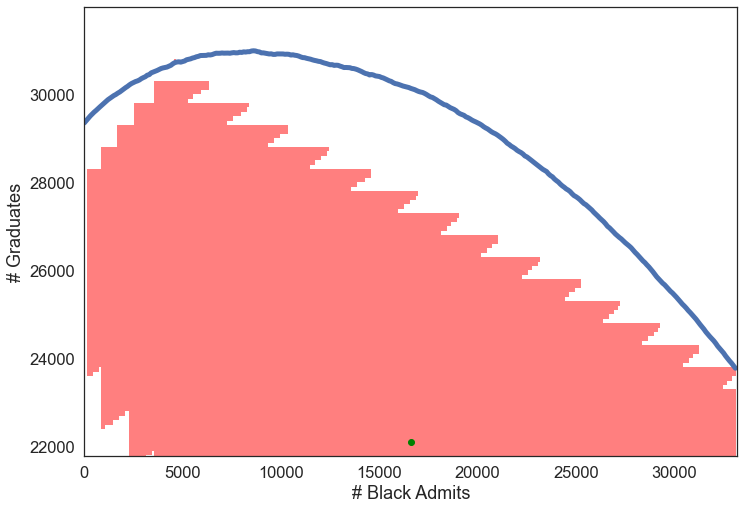

In [12]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    
